# Importing the necessarry python packages

In [81]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import matplotlib as mpl
import glob
import matplotlib
from scipy.io import FortranFile
import struct
import os


# Path were the test-suite is located
current_dir   = # Add the test suite path here
bin_dir       = # Add the bin directory here
NUM_THREAD = 8 # This depends on your machine, this is the number of threads you want to use with openmp


# Default compilation options for the tests

In [82]:
OPENMP     = 1 # We use the openmp speedup
SOLVER     = 2 # HLL
SOLVERDUST = 0 # Huang & Bai 2021, if applicable : if dust is included
RESOLUTION = 1024 # Default resolution
default_compils={'OPENMP':OPENMP,"NUM_THREAD":NUM_THREAD,'SOLVER':SOLVER,'SOLVERDUST':SOLVERDUST,"RESOLUTION":RESOLUTION}

# Functions to read the data from shark

In [88]:
def read_var(filename,varname,size):
    f=open(filename+"/"+varname, "rb")
    dat = np.fromfile(f, dtype=np.float64, count=size, sep='')
    return dat

def read_parameter_file(fname="",evaluate=True,verbose=True,delimiter="="):
    # Read info file and create dictionary
    try:
        with open(fname) as f:
            content = f.readlines()
        f.close()
    except IOError:
        # Clean exit if the file was not found
        if verbose:
            print("File not found: "+fname)
        return 0
    infos={}
    for line in content:
        sp = line.split(delimiter)
        #print(sp)
        if len(sp) > 1:
            if evaluate:
                try:
                    infos[sp[0].strip()] = eval(sp[1].strip())
                except (NameError,SyntaxError):
                    infos[sp[0].strip()] = sp[1].strip()
            else:
                infos[sp[0].strip()] = sp[1].strip()
    return infos

def read_output(number,path='.'):
    
    if(number==-1):
        filelist = sorted(glob.glob(path+"/output*"))
        number = filelist[-1].split("_")[-1]
    print('Reading output '+str(number))
    data={}
    filename= path+"/output_"+ str(number).zfill(5)
    infos=read_parameter_file(fname=filename+'/info.dat')
    data['infos']=infos
    for key in infos:
        print(key+' = ',infos[key])
    
    NX          = infos["NX"]
    NY          = infos["NY"]
    NDUST       = infos["ndust"]
    GEOM        = infos['GEOM']
    GRIDSPACE   = infos['GRIDSPACE']
    data['x']   = read_var(filename,'x',NX*NY)
    if(NY>1):
        data['y']   = read_var(filename,'y',NX*NY)
    
    vx   = read_var(filename,'v',NX*NY)
    vy   = read_var(filename,'vy',NX*NY)
    P    = read_var(filename,'P',NX*NY)
    rho  = read_var(filename,'rho',NX*NY)

    if(NDUST>0):
        rhod   = read_var(filename,'rhod',NX*NY*NDUST)
        vdx    = read_var(filename,'vd', NX*NY*NDUST)
        vdy    = read_var(filename,'vdy',NX*NY*NDUST)
        if(NY>1):
            data['rhod'] = np.reshape(rhod,(NY,NX),order = "C").T
            data['vdx']  = np.reshape(vdx,(NY,NX),order = "C").T
            data['vdy']  = np.reshape(vdy,(NY,NX),order = "C").T
        else:
            data['rhod'] = rhod
            data['vdx']  = vdx
            data['vdy']  = vdy
    
    if(NY>1):      
        data['rho'] = np.reshape(rho,(NY,NX),order = "C").T
        data['vx']  = np.reshape(vx,(NY,NX),order = "C").T
        data['vy']  = np.reshape(vy,(NY,NX),order = "C").T
    else:
        data['rho'] = rho
        data['vx']  = vx
        data['vy']  = vy
        data['P']   = P
        
    if(GEOM==2): 
        r=np.linspace(1,400,NX)
        if(GRIDSPACE==1):
            r=np.logspace(np.log10(1),np.log10(400),NX)
        data['r']=r
        data['theta']=np.linspace(0,2.*np.pi,NY)
    return data

# Functions to run the tests

In [89]:
def run_test(test='Sod-tube',path_suite=current_dir,options=default_compils,visu=True):
    if(test=="Sod-tube"):
        flags="SETUP=SOD NX="+str(default_compils["RESOLUTION"])+" NY=1 NGHOST=2 OPENMP="+str(default_compils["OPENMP"])+" DEBUG=0 SOLVER="+str(default_compils["SOLVER"])
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(current_dir+'/'+test)
        os.system(bin_dir+'/shark sod.nml')
        data_ana = np.loadtxt(current_dir+'/'+test+'/solution.dat')
        x_ana    = data_ana[:,1]
        rho_ana  = data_ana[:,3]
        u_ana    = data_ana[:,2]
        p_ana    = data_ana[:,4]
        T_ana    = data_ana[:,5]*1.2027e-8/2.5
        
        data=read_output(-1)
        plt.plot(x_ana,rho_ana,color='k',label='analytical solution')
        plt.plot(data['x'],data['rho'],color='r',linestyle='dashed',label='SHARK')
        plt.xlabel("x")
        plt.ylabel("density [code units]")
        plt.legend()
        plt.show()
        os.chdir(current_dir)

# Tests

## Test 1 : Sod-tube

This is the first test to be ran, this is a simple 1D simulation of a propagating shock. This test has an analytical solution and serves as a validation of the gas.

You are compiling with the options SETUP=SOD NX=1024 NY=1 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2
Reading output 00002
nvar =  5
ndust =  0
NX =  1024
NY =  1
MHD =  0
GEOM =  0
GRIDSPACE =  0
time =  0.245211858484452
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0
charging =  0


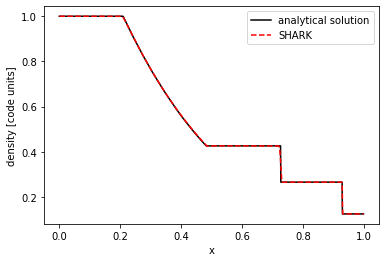

In [90]:
run_test(test='Sod-tube')